# Using metrics to assess the performance of your neural network
----

Hello everyone! In this tutorial, we are going to learn how to use various metrics in order to assess the performance of our neural networks. I have chosen to work on three cases:
* *multi-classification*
* *imbalanced binary classification*
* *regression*

I believe these cases are diverse enough to help you in any machine learning project you will encounter further. 
If you would like me to add any extra metrics that are not encountered below, please let me know and I will do my best to add them later on. So, let's get started :)!

** TensorFlow version used - 1.5 **


## Import useful libraries and enable eager mode
----

In [1]:
# Suppress future warnings
import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import TensorFlow and TensorFlow Eager
import tensorflow as tf
import tensorflow.contrib.eager as tfe

# Import functions to generate toy classication problems
from sklearn.datasets import load_wine

# Import numpy for data preprocessing
import numpy as np

# Import library for plots
import matplotlib.pyplot as plt
%matplotlib inline

# Import PCA for dimensionality reduction
from sklearn.decomposition import PCA

In [2]:
# Enable eager mode. Once activated it cannot be reversed! Run just once.
tfe.enable_eager_execution()

## Create dataset for multi-classification
----

In [3]:
wine_data = load_wine()

In [4]:
print('Type of data in the wine_data dictionary: ', list(wine_data.keys()))

Type of data in the wine_data dictionary:  ['data', 'target', 'target_names', 'DESCR', 'feature_names']


In [5]:
print('Number of classes: ', len(np.unique(wine_data.target)))

Number of classes:  3


In [6]:
print('Distribution of our targets: ', np.unique(wine_data.target, return_counts=True)[1])

Distribution of our targets:  [59 71 48]


In [7]:
print('Number of features in the dataset: ', wine_data.data.shape[1])

Number of features in the dataset:  13


## Standardize features
----
The scale of each feature varies a lot as you can see in the cell below. In order to speed up the training, we will normalize each feature to have zero mean and unit standard deviation. This process is called standardization and it is very helpful in the convergence of the neural network. 

In [8]:
print('Mean of each feature: ', np.mean(wine_data.data, axis=0))

Mean of each feature:  [1.30006180e+01 2.33634831e+00 2.36651685e+00 1.94949438e+01
 9.97415730e+01 2.29511236e+00 2.02926966e+00 3.61853933e-01
 1.59089888e+00 5.05808988e+00 9.57449438e-01 2.61168539e+00
 7.46893258e+02]


In [9]:
# Standardize dataset
wine_data.data = (wine_data.data - np.mean(wine_data.data, axis=0))/np.std(wine_data.data, axis=0)

In [10]:
print('Mean of each feature after standardization: ', np.mean(wine_data.data, axis=0))

Mean of each feature after standardization:  [ 7.84141790e-15  2.44498554e-16 -4.05917497e-15 -7.11041712e-17
 -2.49488320e-17 -1.95536471e-16  9.44313292e-16 -4.17892936e-16
 -1.54059038e-15 -4.12903170e-16  1.39838203e-15  2.12688793e-15
 -6.98567296e-17]


In [11]:
print('Standard deviation of each feature after standardization: ', np.std(wine_data.data, axis=0))

Standard deviation of each feature after standardization:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


##  Data visualization. Use PCA to reduce the dimensionality to 2D.
----
We will use PCA, only for visualization purposes. We will be training our neural network using all 13 features. 

Let's have a look at how these 3 classes are represented in the 2D space.

In [12]:
X_pca = PCA(n_components=2, random_state=2018).fit_transform(wine_data.data)

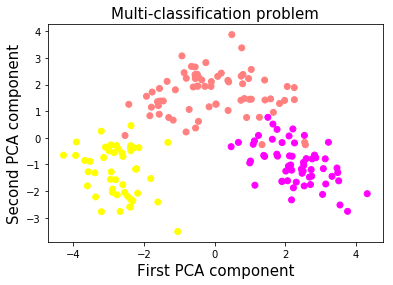

In [13]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=wine_data.target, cmap=plt.cm.spring)
plt.xlabel('First PCA component', fontsize=15)
plt.ylabel('Second PCA component', fontsize=15)
plt.title('Multi-classification problem', fontsize=15)
plt.show()

Okay, so it appears that the classes are easily separable. By the way, I actually tried using PCA before standardizing the features and the pink and yellow classes were overlapping. By standardizing the features before reducing the dimensionality we managed to obtain a much clear boundary between them. 

## Let's build a two-layers neural network using the TensorFlow Eager API
----

As you might have noticed, the most convenient way to build models using TensorFlow Eager is with classes. I think that using classes for your models makes it much easier to organize and adding new components to it. You simply define the layers that you're going to use during initialization and use them later on at the predict stage. It makes it easier to read the architecture of the model during the predict stage.

In [14]:
class two_layer_nn(tfe.Network):
    def __init__(self, num_classes=3):
        # First hidden layer
        self.dense_1 = tf.layers.Dense(20, activation=tf.nn.relu)
        # Second hidden layer
        self.dense_2 = tf.layers.Dense(10, activation=tf.nn.relu)
        # Output layer. Unscaled log probabilities
        self.dense_out = tf.layers.Dense(num_classes, activation=None)
    
    def predict(self, X):
        layer_1 = self.dense_1(X)
        layer_2 = self.dense_2(layer_1)
        logits = self.dense_out(layer_2)
        return logits

## Define loss function, optimizer and gradients function
----
** Important!** - When using the function 'tfe.implicit_gradients', it is important to run the forward pass of the model in the 'loss_fn' function. Otherwise, the function will not find any variable to compute the gradient for.

In [44]:
# Initialize model 
model = two_layer_nn(num_classes=3)

In [45]:
# Define loss function
def loss_fn(model, X, y):
    logits = model.predict(X)
    return tf.losses.sparse_softmax_cross_entropy(y, logits)

In [46]:
# Define optimizer
optimizer = tf.train.GradientDescentOptimizer(5e-1)

In [47]:
# Function to compute the gradients of variables with respect to the loss function
grads_fn = tfe.implicit_gradients(loss_fn)

## Accuracy metric
----
To assess the performance of our model using the accuracy metric, we will be using the 'tfe.metrics.Accuracy' class. This metric is really useful when training a model in batches, as it computes the mean accuracy across batches each time it is called. As we train our model with the entire dataset at each step, we will be resetting this metric, as we do not want it to track the running mean.

In [48]:
accuracy = tfe.metrics.Accuracy()

In [49]:
# Create input features and targets dataset. Transfer data from numpy to tensors.
X = tf.constant(wine_data.data)
y = tf.constant(wine_data.target)

In [50]:
# Specify number of epochs
num_epochs = 50

# Create empty list to store the accuracy of each epoch
hist_accuracy = []

for i in range(num_epochs):
    # One step of gradient descent
    optimizer.apply_gradients(grads_fn(model, X, y))
    # Predict targets after taking a step of gradient descent
    logits = model.predict(X)
    preds = tf.argmax(logits, axis=1)
    # Compute the accuracy
    accuracy(preds, y)
    # Get the actual result and add it to our list
    hist_accuracy.append(accuracy.result())
    # Reset accuracy value (we don't want to track the running mean accuracy)
    accuracy.init_variables()
    

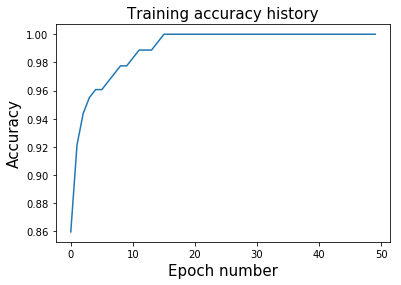

In [51]:
plt.plot(range(num_epochs), hist_accuracy);
plt.xlabel('Epoch number', fontsize=15);
plt.ylabel('Accuracy', fontsize=15);
plt.title('Training accuracy history', fontsize=15);

## Confusion matrix
----
Visualizing the confusion matrix after you finished training the algorithm is a great way to give you global overview on the performance of your network. TensorFlow has a built-in function to compute the confusion matrix and fortunately it is compatible with eager mode. So let's visualize the confusion matrix of this dataset.

In [52]:
# Get the predictions on the entire dataset
logits = model.predict(X)
preds = tf.argmax(logits, axis=1)

In [53]:
# Print confusion matrix
conf_matrix = tf.confusion_matrix(y, preds, num_classes=3)
print(conf_matrix.numpy())

[[59  0  0]
 [ 0 71  0]
 [ 0  0 48]]


As we have overfit the training dataset, the neural network makes perfect predictions.

## Mean average precision
----
To my knowledge, Tens